In [4]:
source("/root/workspace/code/midas/preprocess/utils.R")
setwd("/root/workspace/code/midas/")
library(RColorBrewer)
library(patchwork)

parser <- ArgumentParser()
parser$add_argument("--task", type = "character", default = "atlas")
parser$add_argument("--method", type = "character", default = "midas_embed")
parser$add_argument("--experiment", type = "character", default = "e0")
parser$add_argument("--model", type = "character", default = "default")
parser$add_argument("--init_model", type = "character", default = "sp_latest")
o <- parser$parse_known_args()[[1]]

config <- parseTOML("configs/data.toml")[[gsub("_transfer$|_ref_.*$", "", o$task)]]
subset_names <- basename(config$raw_data_dirs)
subset_ids <- sapply(seq_along(subset_names) - 1, toString)
input_dirs <- pj("result", o$task, o$experiment, o$model, "predict", o$init_model, paste0("subset_", subset_ids))
pp_dir <- pj("data", "processed", o$task)
output_dir <- pj("result", "comparison", o$task, o$method, o$experiment, o$init_model)
mkdir(output_dir, remove_old = F)
label_paths <- pj(config$raw_data_dirs, "label_seurat", "l1.csv")

K <- parseTOML("configs/model.toml")[["default"]]$dim_c
l <- 7.5  # figure size
L <- 10   # figure size
m <- 0.5  # legend margin

## Load preprossed data

In [5]:
z_list <- list()
cell_name_list <- list()
label_list <- list()
is_label <- T
subset_name_list <- list()
S <- length(subset_names)
for (i in seq_along(subset_names)) {
    subset_name <- subset_names[i]
    z_dir    <- pj(input_dirs[i], "z", "joint")
    fnames <- dir(path = z_dir, pattern = ".csv$")
    fnames <- str_sort(fnames, decreasing = F)

    z_subset_list <- list()
    N <- length(fnames)
    for (n in seq_along(fnames)) {
        message(paste0("Loading Subset ", i, "/", S, ", File ", n, "/", N))
        z_subset_list[[n]] <- read.csv(file.path(z_dir, fnames[n]), header = F)
    }
    z_list[[subset_name]] <- bind_rows(z_subset_list)

    cell_name_list[[subset_name]] <- read.csv(pj(pp_dir, paste0("subset_", subset_ids[i]),
        "cell_names.csv"), header = T)[, 2]
    if (file.exists(label_paths[i])) {
        label_list[[subset_name]] <- read.csv(label_paths[i], header = T)[, 2]
    } else {
        is_label <- F
    }
    
    subset_name_list[[subset_name]] <- rep(subset_name, length(cell_name_list[[subset_name]]))
}

Loading Subset 1/27, File 1/29

Loading Subset 1/27, File 2/29

Loading Subset 1/27, File 3/29

Loading Subset 1/27, File 4/29

Loading Subset 1/27, File 5/29

Loading Subset 1/27, File 6/29

Loading Subset 1/27, File 7/29

Loading Subset 1/27, File 8/29

Loading Subset 1/27, File 9/29

Loading Subset 1/27, File 10/29

Loading Subset 1/27, File 11/29

Loading Subset 1/27, File 12/29

Loading Subset 1/27, File 13/29

Loading Subset 1/27, File 14/29

Loading Subset 1/27, File 15/29

Loading Subset 1/27, File 16/29

Loading Subset 1/27, File 17/29

Loading Subset 1/27, File 18/29

Loading Subset 1/27, File 19/29

Loading Subset 1/27, File 20/29

Loading Subset 1/27, File 21/29

Loading Subset 1/27, File 22/29

Loading Subset 1/27, File 23/29

Loading Subset 1/27, File 24/29

Loading Subset 1/27, File 25/29

Loading Subset 1/27, File 26/29

Loading Subset 1/27, File 27/29

Loading Subset 1/27, File 28/29

Loading Subset 1/27, File 29/29

Loading Subset 2/27, File 1/24

Loading Subset 2/27,

## Create seurat object

In [6]:
rna <- t(data.matrix(bind_rows(z_list))) * 0  # pseudo rna counts
colnames(rna) <- do.call("c", unname(cell_name_list))
rownames(rna) <- paste0("rna-", seq_len(nrow(rna)))
obj <- CreateSeuratObject(counts = rna, assay = "rna")

z <- data.matrix(bind_rows(z_list))
c <- z[, 1:K]
colnames(c) <- paste0("c_", seq_len(ncol(c)))
rownames(c) <- colnames(obj)
obj[["c"]] <- CreateDimReducObject(embeddings = c, key = "c_", assay = "rna")

u <- z[, (K+1):(K+2)]
colnames(u) <- paste0("u_", seq_len(ncol(u)))
rownames(u) <- colnames(obj)
obj[["u"]] <- CreateDimReducObject(embeddings = u, key = "u_", assay = "rna")

obj@meta.data$batch <- factor(x = do.call("c", unname(subset_name_list)), levels = subset_names)
table(obj@meta.data$batch)[unique(obj@meta.data$batch)]

cell_label <- readRDS("result/analysis/atlas/label_transfer_atlas_cca_all.rds")
cell_label <- do.call("bind_rows", unname(cell_label))
cell_label <- cell_label[colnames(obj), ]
obj@meta.data$l1 <- cell_label$predicted.celltype.l1
obj@meta.data$l1 <- factor(obj@meta.data$l1, levels = str_sort(unique(obj@meta.data$l1)))

obj


                lll_ctrl                 lll_stim                 dig_ctrl 
                    7361                     5897                    10190 
                dig_stim                       w1                       w3 
                    9527                     7325                     6587 
                      w4                       w5                       w6 
                    6897                     6910                     7137 
            tea_multi_w1             tea_multi_w2 10x_multiome_chrom_x_10k 
                    6096                     7284                     9868 
10x_multiome_chrom_c_10k    10x_multiome_arc2_10k     10x_multiome_arc2_3k 
                    9582                    11116                     2566 
               asap_ctrl                asap_stim                cite_ctrl 
                    4255                     5241                     5086 
               cite_stim                     p1_0                     p2_0 
           

An object of class Seurat 
34 features across 185518 samples within 1 assay 
Active assay: rna (34 features, 0 variable features)
 2 dimensional reductions calculated: c, u

## Visualization

In [ ]:
obj <- RunUMAP(obj, reduction = 'c', dims = 1:K, reduction.name = 'c.umap')
obj <- RunUMAP(obj, reduction = 'u', dims = 1:2, metric = "euclidean", reduction.name = 'u.umap')
SaveH5Seurat(obj, pj(output_dir, "obj.h5seurat"), overwrite = TRUE)
# obj <- LoadH5Seurat(pj(output_dir, "obj.h5seurat"), reductions = c("c.umap", "u.umap"))

### Split view (by batch)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To di

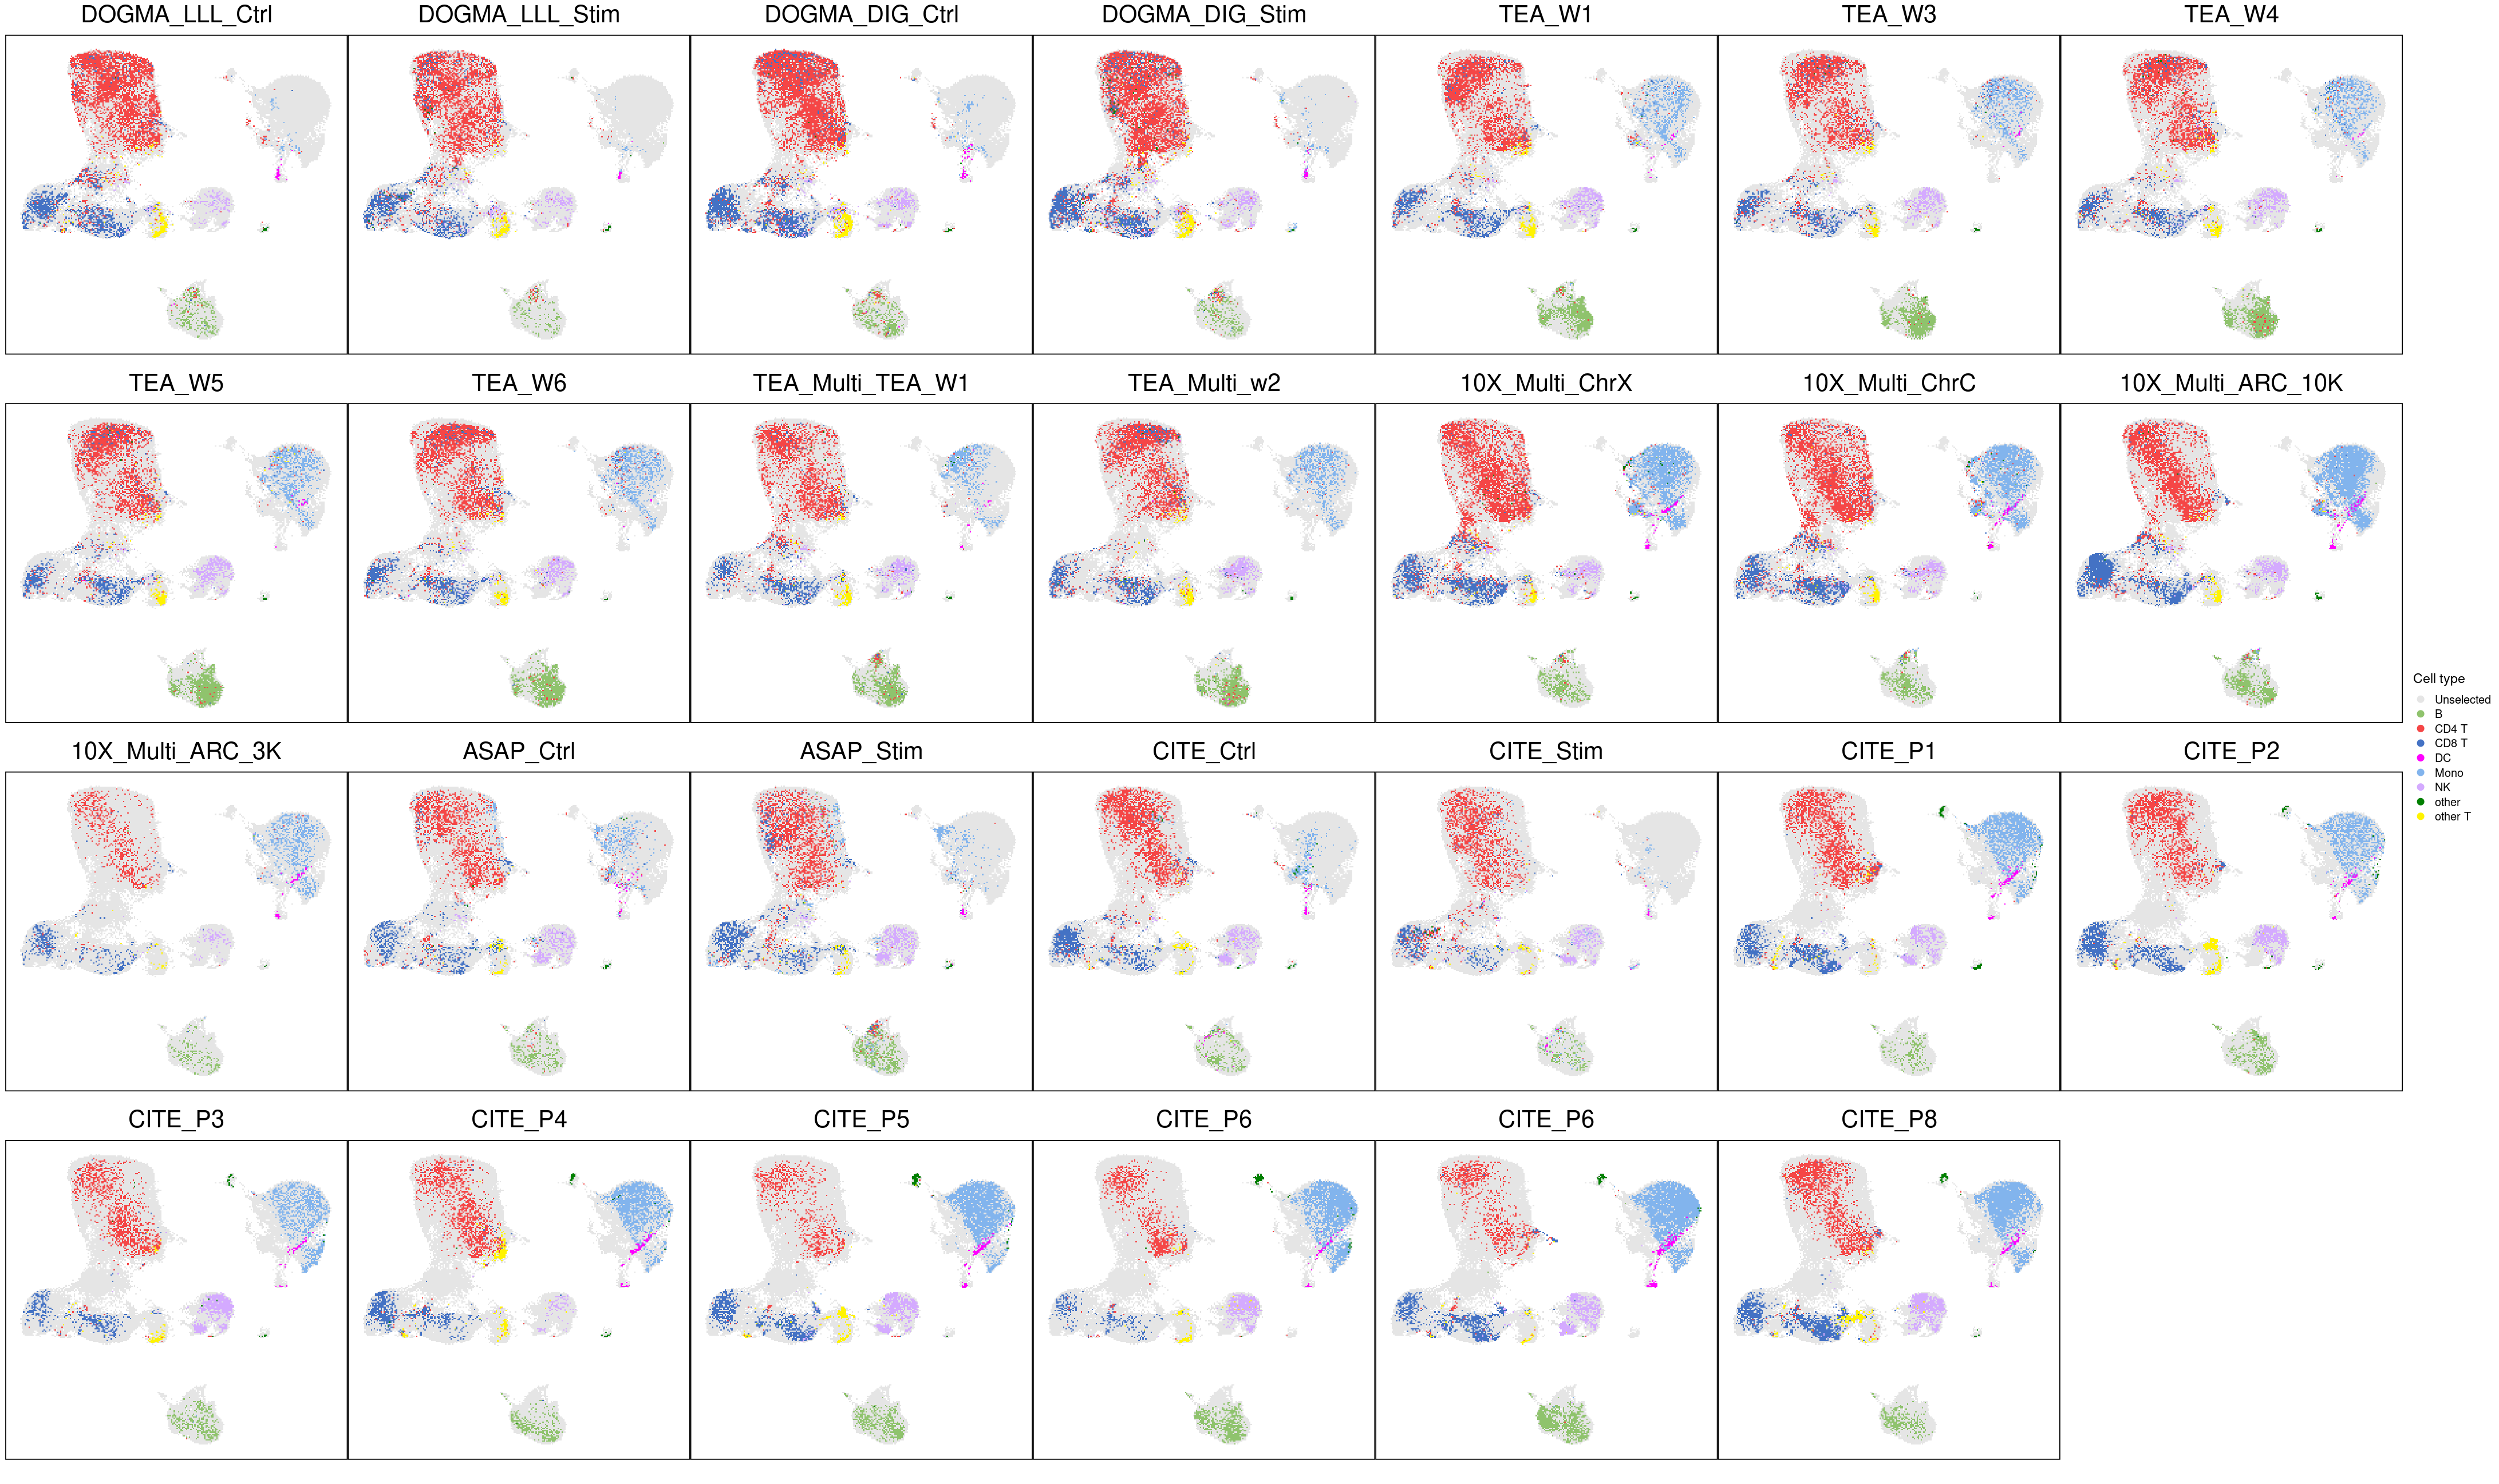

In [44]:
obj_batch <- SplitObject(obj, split.by = "batch")

pal <- col_8
labels <- str_sort(unique(obj@meta.data$l1))
label_to_color <- list()
for (i in seq_along(labels)) {
    label_to_color[[labels[i]]] <- pal[i]
}
order <- c(str_sort(unique(obj@meta.data$l1), decreasing = T), "Unselected")
plt <- NULL

for (s in subset_names) {

    # set groups for highlighting
    obj@meta.data$highlight <- "Unselected"
    select_mask <- colnames(obj) %in% colnames(obj_batch[[s]])
    obj@meta.data$highlight[select_mask] <- as.character(obj@meta.data$l1[select_mask])
    # set label-specific colors
    cols <- c("#E5E5E5")
    for (label in str_sort(unique(obj_batch[[s]]@meta.data$l1))) {
        cols <- c(cols, label_to_color[[label]])
    }
    # plot
    p <- DimPlot(obj, reduction = "c.umap", group.by = "highlight", repel = T,
            label.size = 4, pt.size = 0.1, shuffle = F, cols = cols, order = order, raster = T, raster.dpi = c(250, 250))

    s_ <- gsub("lll_ctrl", "DOGMA_LLL_Ctrl",
          gsub("lll_stim", "DOGMA_LLL_Stim",
          gsub("dig_ctrl", "DOGMA_DIG_Ctrl",
          gsub("dig_stim", "DOGMA_DIG_Stim",
          gsub("w1", "TEA_W1",
          gsub("w3", "TEA_W3",
          gsub("w4", "TEA_W4",
          gsub("w5", "TEA_W5",
          gsub("w6", "TEA_W6",
          gsub("tea_multi_w1", "TEA_Multi_w1",
          gsub("tea_multi_w2", "TEA_Multi_w2",
          gsub("10x_multiome_chrom_x_10k", "10X_Multi_ChrX",
          gsub("10x_multiome_chrom_c_10k", "10X_Multi_ChrC",
          gsub("10x_multiome_arc2_10k", "10X_Multi_ARC_10K",
          gsub("10x_multiome_arc2_3k", "10X_Multi_ARC_3K",
          gsub("asap_ctrl", "ASAP_Ctrl",
          gsub("asap_stim", "ASAP_Stim",
          gsub("cite_ctrl", "CITE_Ctrl",
          gsub("cite_stim", "CITE_Stim",
          gsub("p1_0", "CITE_P1",
          gsub("p2_0", "CITE_P2",
          gsub("p3_0", "CITE_P3",
          gsub("p4_0", "CITE_P4",
          gsub("p5_0", "CITE_P5",
          gsub("p6_0", "CITE_P6",
          gsub("p7_0", "CITE_P6",
          gsub("p8_0", "CITE_P8", s)))))))))))))))))))))))))))
    p <- p + ggtitle(s_) + theme(plot.title = element_text(face = "plain", hjust = 0.5, size = 25))
    p <- p  + NoLegend() + NoAxes() +
        theme(panel.border = element_rect(color = "black", linewidth = 1),
        axis.ticks.length = unit(0, "pt"), plot.margin = margin(0, 0, 20, 0)) +
        labs(colour = "Cell type")
    if (!is_label) {
        p <- p + NoLegend()
    }
    if (is.null(plt)) {
        plt <- p
    } else {
        plt <- plt + p
    }
}

plt <- plt + plot_layout(ncol = 7, guides = "collect") & theme(legend.position = "right")

w <- 5 * 7 + 1.38
h <- 5 * 4 + 1.6
plt_size(w, h)
plt
save_path <- pj(output_dir, paste("4a_", o$task, o$method, o$experiment, o$init_model, "c_all", sep = "_"))
ggsave(plot = plt, file = paste0(save_path, ".png"), width = w, height = h, limitsize = F)
ggsave(plot = plt, file = paste0(save_path, ".pdf"), width = w, height = h, limitsize = F)

### Split view (by dataset)


       DOGMA (4 batches)          TEA (5 batches) TEA Multiome (2 batches) 
                   32975                    34856                    13380 
10X Multiome (4 batches)         ASAP (2 batches)    ASAP CITE (2 batches) 
                   33132                     9496                     8715 
    WNN CITE (8 batches) 
                   52964 

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



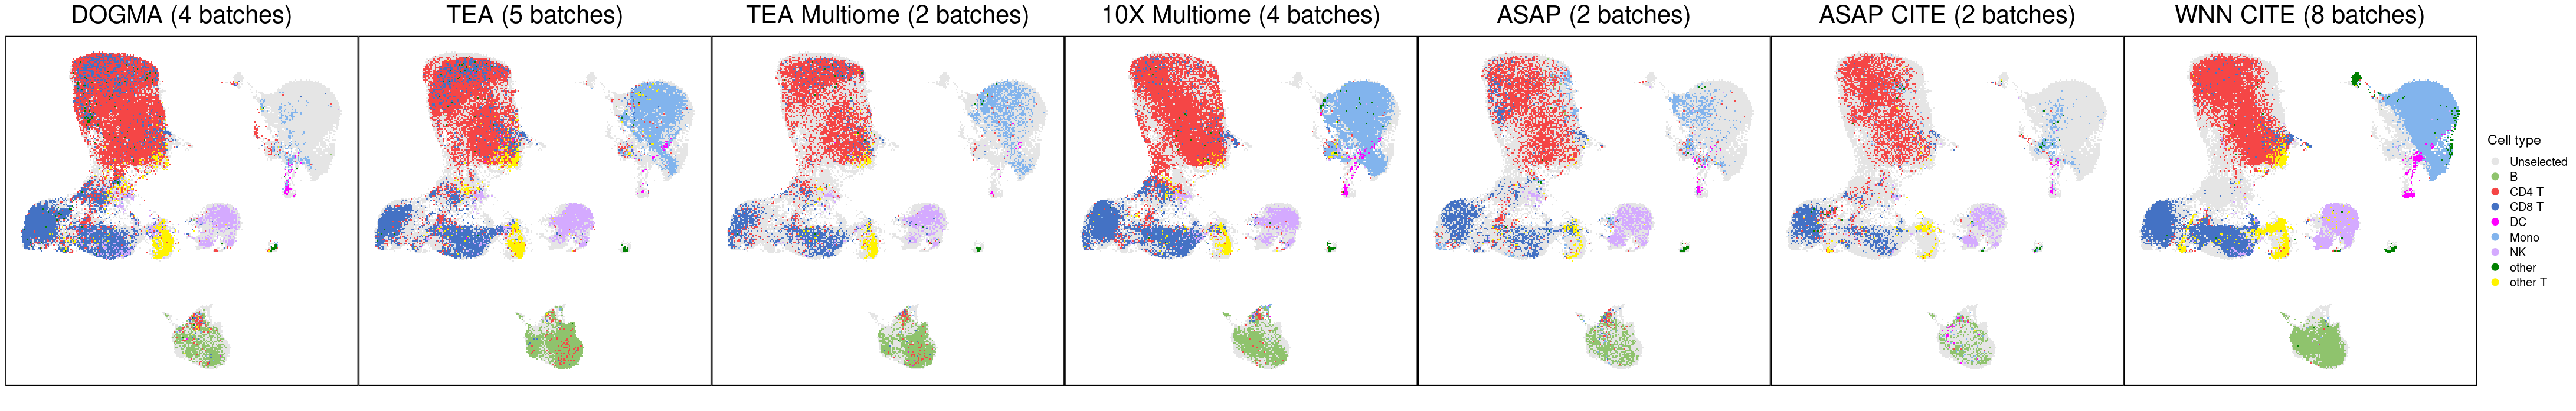

In [45]:
dataset <- as.character(obj@meta.data$batch)
dataset[dataset %in% c("lll_ctrl", "lll_stim", "dig_ctrl", "dig_stim")] <- "DOGMA (4 batches)"
dataset[dataset %in% c("w1", "w3", "w4", "w5", "w6")] <- "TEA (5 batches)"
dataset[grepl("tea_multi", dataset)] <- "TEA Multiome (2 batches)"
dataset[grepl("10x_multiome", dataset)] <- "10X Multiome (4 batches)"
dataset[dataset %in% c("asap_ctrl", "asap_stim")] <- "ASAP (2 batches)"
dataset[dataset %in% c("cite_ctrl", "cite_stim")] <- "ASAP CITE (2 batches)"
dataset[grepl("p*_0", dataset)] <- "WNN CITE (8 batches)"
obj@meta.data$dataset <- factor(dataset, levels = c("DOGMA (4 batches)", "TEA (5 batches)", "TEA Multiome (2 batches)",
    "10X Multiome (4 batches)", "ASAP (2 batches)", "ASAP CITE (2 batches)", "WNN CITE (8 batches)"))
table(obj@meta.data$dataset)

obj_dataset <- SplitObject(obj, split.by = "dataset")

pal <- col_8
labels <- str_sort(unique(obj@meta.data$l1))
label_to_color <- list()
for (i in seq_along(labels)) {
    label_to_color[[labels[i]]] <- pal[i]
}
order <- c(str_sort(unique(obj@meta.data$l1), decreasing = T), "Unselected")
plt <- NULL

for (s in unique(obj@meta.data$dataset)) {

    # set groups for highlighting
    obj@meta.data$highlight <- "Unselected"
    select_mask <- colnames(obj) %in% colnames(obj_dataset[[s]])
    obj@meta.data$highlight[select_mask] <- as.character(obj@meta.data$l1[select_mask])
    # set label-specific colors
    cols <- c("#E5E5E5")
    for (label in str_sort(unique(obj_dataset[[s]]@meta.data$l1))) {
        cols <- c(cols, label_to_color[[label]])
    }
    # plot
    p <- DimPlot(obj, reduction = "c.umap", group.by = "highlight", repel = T,
            label.size = 4, pt.size = 0.1, shuffle = F, cols = cols, order = order, raster = T, raster.dpi = c(250, 250))
    p <- p + ggtitle(s) + theme(plot.title = element_text(face = "plain", hjust = 0.5, size = 25))
    p <- p  + NoLegend() + NoAxes() +
        theme(panel.border = element_rect(color = "black", linewidth = 1),
        axis.ticks.length = unit(0, "pt"), plot.margin = margin(0, 0, 20, 0)) +
        labs(colour = "Cell type")
    if (!is_label) {
        p <- p + NoLegend()
    }
    if (is.null(plt)) {
        plt <- p
    } else {
        plt <- plt + p
    }
}

plt <- plt + plot_layout(ncol = 7, guides = "collect") & theme(legend.position = "right")
w <- 5 * 7 + 1.38
h <- 5 * 1 + 0.8
plt_size(w, h)
plt
save_path <- pj(output_dir, paste("4a_", o$task, o$method, o$experiment, o$init_model, "c_all_reduced_300", sep = "_"))
ggsave(plot = plt, file = paste0(save_path, ".png"), width = w, height = h, limitsize = F)
ggsave(plot = plt, file = paste0(save_path, ".pdf"), width = w, height = h, limitsize = F)

### Merged view

In [14]:
# merged umap

## with legend
dim_plot(obj, w = L+3, h = L, reduction = 'c.umap', no_axes = T, raster = T, raster_dpi = 500,
    split.by = NULL, group.by = "l1", label = F, repel = T, label.size = 4, pt.size = 0.1, cols = col_8, legend = T,
    save_path = pj(output_dir, paste(o$task, o$method, o$experiment, o$init_model, "c_merged_label_lg", sep = "_")))

dim_plot(obj, w = L+3, h = L, reduction = 'u.umap', no_axes = T, raster = T, raster_dpi = 500,
    split.by = NULL, group.by = "batch", label = F,  repel = T, label.size = 4, pt.size = 0.1, cols = col_27, legend = T,
    save_path = pj(output_dir, paste(o$task, o$method, o$experiment, o$init_model, "u_merged_batch_lg", sep = "_")))

## without legend
dim_plot(obj, w = L, h = L, reduction = 'c.umap', no_axes = T, raster = T, raster_dpi = 500,
    split.by = NULL, group.by = "l1", label = F, repel = T, label.size = 4, pt.size = 0.1, cols = col_8, legend = F,
    save_path = pj(output_dir, paste(o$task, o$method, o$experiment, o$init_model, "c_merged_label", sep = "_")))

dim_plot(obj, w = L, h = L, reduction = 'u.umap', no_axes = T, raster = T, raster_dpi = 500,
    split.by = NULL, group.by = "batch", label = F,  repel = T, label.size = 4, pt.size = 0.1, cols = col_27, legend = F,
    save_path = pj(output_dir, paste(o$task, o$method, o$experiment, o$init_model, "u_merged_batch", sep = "_")))


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

